In [2]:
#imports
from os.path import abspath,join,dirname,normpath,basename
from os import makedirs,rename,rmdir
import requests,zipfile,io
import shutil
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import math

In [3]:
# functions
# replaces NaN value with mean if too much, else just removes (this is from my clinic, it's not perfect)
def handling_nan(given_data, thres):
    number_of_rows = given_data.shape[0]
    num_of_nan = given_data.isna().sum()
    num_of_minus = 0


    for i in range(len(given_data.columns)):
        col = given_data.columns[i]

        # checks if col is int or float (so we can replace it with median -> with median because if we take the mean for replacing then it would mess up the nominal features)
        if (given_data.dtypes[i] == np.float64) or (given_data.dtypes[i] == np.int64):

            # col has nan or -1 (what the "factorize" function turns nan into)
            if (num_of_nan[i] != 0) or (-1 in given_data[col].unique()):

                # variables for replacing
                df_without_minus = given_data[given_data[col] != -1]
                median_of_col = df_without_minus[col].median()

                # even though unlikely, the median can be nan -> so setting to 0 as default
                if math.isnan(median_of_col):
                    median_of_col = 0

                # if col contains -1, get how many -1 it contains
                if -1 in given_data[col].unique():
                    num_of_minus = given_data[col].value_counts()[-1]

                # too many nan, can't drop so replace with mean
                if num_of_nan[i] + num_of_minus > (number_of_rows * thres):
                    given_data[col].fillna(median_of_col, inplace = True)
                    given_data[col] = given_data[col].replace([-1], median_of_col)

                else:
                    # meaning we can drop, so we just take the rows without NaN in that column
                    given_data = given_data[given_data[col].notna()]
                    given_data = given_data[given_data[col] != -1]

    return given_data

# 1. Uploading Data

Note: This part has to be ran only once.

In [ ]:
#Setup data
data_folder=join(dirname(abspath('')),'data')
makedirs(data_folder,exist_ok=True)

In [ ]:
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
base_link = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-YEAR.zip"
for year in years:
    link = base_link.replace('YEAR',year)
    download = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(download.content))
    all_members = z.filelist
    for member in all_members:
        name = member.filename
        if '.csv' in name and 'MACOS' not in name:
            print(f"Extracting {name}")
            entire_path = z.extract(member,path=data_folder)
            print("done")
            path = basename(normpath(entire_path))
            if year not in path:
                rename(entire_path,entire_path.replace('.csv',f'{year}.csv'))


In [ ]:
#Fix one broken path
folder_path = join(data_folder,'2016 Stack Overflow Survey Results')
fix_path = join(data_folder,'2016 Stack Overflow Survey Responses.csv')
broken_path = join(folder_path,'2016 Stack Overflow Survey Responses.csv')
shutil.move(broken_path,fix_path)
rmdir(folder_path)

# 2. Perform EDA

Extracting data

In [4]:
# taking common path
data_folder=join(dirname(abspath('')),'data')

# taking public data
public_data = [pd.read_csv(join(data_folder, 'survey_results_public2020.csv')),
               pd.read_csv(join(data_folder, 'survey_results_public2021.csv')),
               pd.read_csv(join(data_folder, 'survey_results_public2022.csv'))]

# taking schema data
schema_data = [pd.read_csv(join(data_folder, 'survey_results_schema2020.csv')),
               pd.read_csv(join(data_folder, 'survey_results_schema2021.csv')),
               pd.read_csv(join(data_folder, 'survey_results_schema2022.csv'))]


#### NaN values

Checking NaN

In [5]:
for current_data in public_data:
    print(current_data.isna().sum())

Respondent                0
MainBranch              299
Hobbyist                 45
Age                   19015
Age1stCode             6561
                      ...  
WebframeWorkedWith    22182
WelcomeChange         11778
WorkWeekHrs           23310
YearsCode              6777
YearsCodePro          18112
Length: 61, dtype: int64
ResponseId                          0
MainBranch                          0
Employment                        116
Country                             0
US_State                        68519
UK_Country                      79021
EdLevel                           313
Age1stCode                        196
LearnCode                         476
YearsCode                        1798
YearsCodePro                    22223
DevType                         16955
OrgSize                         22713
Currency                        22359
CompTotal                       36256
CompFreq                        31289
LanguageHaveWorkedWith           1082
LanguageWantToWorkWit

It seems that we have too many features, better to plot them to get a better visual

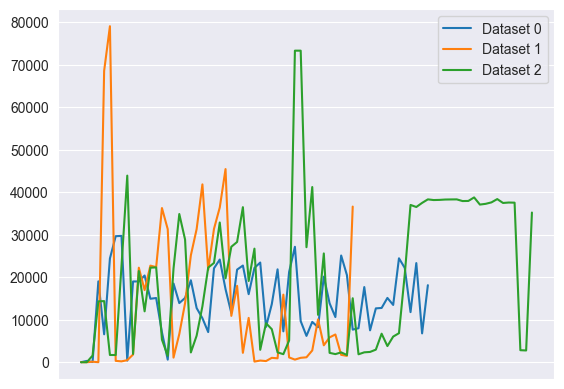

In [6]:
index = 0
# maybe somehow display years too?
for current_data in public_data:
    temp = current_data.isna().sum()
    temp.plot(label="Dataset " + str(index), xticks=[])
    index += 1

plt.legend()

there seems to be many empty data, let's handle them (or not?)

In [7]:
# something

#### General Visualization

In [ ]:
temp = public_data[0]

import matplotlib.pyplot as plt

# fig, axes = plt.subplots(len(temp.columns)//4, 3, figsize=(12, 48))
fig, axes = plt.subplots(len(temp.columns)//6, 6, figsize=(12, 28))

i = 1 # need to start from column 1 since 0 is just ids
# if we could somehow also the title of the question would be really cool
for current_data in public_data:
    for triaxis in axes:
        for axis in triaxis:
            if i < len(temp.columns): # so works until it reaches the last column (so can start from any column)
                temp.iloc[:,i].value_counts().plot(ax=axis, xticks=[])
            i += 1